In [138]:
import numpy as np
import cadquery as cq
from OCP.BRepTools import BRepTools
from OCP.BRepMesh import BRepMesh_IncrementalMesh
from OCP.TopoDS import TopoDS_Face, TopoDS_Shape, TopoDS_Solid, TopoDS
from OCP.TopAbs import TopAbs_Orientation, TopAbs_FACE
from OCP.TopExp import TopExp_Explorer
from OCP.TopLoc import TopLoc_Location
from OCP.BRep import BRep_Tool
import random
from typing import List, Dict
from jupyter_cadquery import show
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

In [139]:
def generate_random_model(n_holes: int = 3) -> cq.Workplane:
    """Generates a random model with holes."""
    if random.random() > 0.5:
        length = random.uniform(5, 15)
        width = random.uniform(5, 15)
        height = random.uniform(5, 15)
        model = cq.Workplane('XY').box(length, width, height)
    else:
        radius = random.uniform(3, 8)
        height = random.uniform(5, 15)
        model = cq.Workplane('XY').circle(radius).extrude(height)
    
    number_holes = random.randint(0, n_holes)
    
    for _ in range(number_holes):
        hole_type = random.choice(['cylinder', 'rectangle'])
        x = random.uniform(-model.val().BoundingBox().xlen/2*0.8, model.val().BoundingBox().xlen/2*0.8)
        y = random.uniform(-model.val().BoundingBox().ylen/2*0.8, model.val().BoundingBox().ylen/2*0.8)
        
        if hole_type == 'cylinder':
            hole_radius = random.uniform(0.5, min(model.val().BoundingBox().xlen, model.val().BoundingBox().ylen)/4)
            model = model.faces(">Z").workplane().moveTo(x, y).circle(hole_radius).cutThruAll()
        else:
            hole_length = random.uniform(1, min(model.val().BoundingBox().xlen, model.val().BoundingBox().ylen)/3)
            hole_width = random.uniform(1, min(model.val().BoundingBox().xlen, model.val().BoundingBox().ylen)/3)
            model = model.faces(">Z").workplane().moveTo(x, y).rect(hole_length, hole_width).cutThruAll()
    
    return number_holes, model

In [140]:
def tessellate_solid(solid: TopoDS_Solid, n_points: int = 1000, tolerance: float = 0.1, angular_tolerance: float = 0.1) -> np.ndarray:
    """Triangulates a solid and returns a random sample of points from the surface."""
    mesh = BRepMesh_IncrementalMesh(solid, tolerance, True, angular_tolerance) # создание объекта сетки (вычисляет триангуляцию)
    mesh.Perform() # заполнение сетки (выполнение триангуляции)
    
    vertices = [] # вершины
    triangles = [] # треугольники
    vertex_offset = 0 # сдвиг для перехода от локальной системы к глобальной 

    explorer = TopExp_Explorer(solid, TopAbs_FACE) # итератор, берущий TopAbs_FACE (вообще все грани, ребра и тд) из solid

    while explorer.More(): # проходимся по итератору, у него 3 метода: .Next(), .More() - "если еще есть", .Current()
        face = TopoDS.Face_s(explorer.Current()) # берем грань из solid и приводим ее к TShape - геометрическое представление + Orientation - СК
        
        loc = TopLoc_Location() # создаем пустой объект локальной СК
        poly = BRep_Tool.Triangulation_s(face, loc) # выполняем разбиение на треугольные КЭ и заполняем локальную СК, структура poly: узлы + треугольники, описанные 3 точками

        if poly is None: # если пусто, то идем к следующему элементу
            explorer.Next()
            continue

        trsf = loc.Transformation() # перевели локальную СК в абсолютную
        is_reversed = (face.Orientation() == TopAbs_Orientation.TopAbs_REVERSED) # смотрим ориентацию, чтобы иметь одно направление для нормалей

        face_vertices = []
        for i in range(1, poly.NbNodes() + 1): # poly.NbNodes() возвращает число узлов
            p = poly.Node(i).Transformed(trsf) # взяли i-й узел и трансформировали в глобальную СК
            face_vertices.append([p.X(), p.Y(), p.Z()]) # засунули массив из трех координат в face_vertices
        
        face_triangles = []
        for i in range(1, poly.NbTriangles() + 1): 
            tri = poly.Triangle(i) # вернет индексы вершин i-го треугольника
            i1, i2, i3 = tri.Value(1), tri.Value(2), tri.Value(3) # индексы вершин записали в i1, i2, i3
            if is_reversed:
                # вычитаем единичку, чтобы перейти в Python-формат
                # (1, 2, 3) - нужное направление нормали, если is_reversed - то делаем нормаль внутрь - (1, 3, 2)
                # "+ vertex_offset" means мы не должны мешать локальные индексы с глобальными.
                # если не добавить vertex_offset, то индексы постоянно будут локальные
                face_triangles.append([i1 - 1 + vertex_offset, i3 - 1 + vertex_offset, i2 - 1 + vertex_offset])
            else:
                face_triangles.append([i1 - 1 + vertex_offset, i2 - 1 + vertex_offset, i3 - 1 + vertex_offset])
        
        vertices.extend(face_vertices)
        triangles.extend(face_triangles)
        vertex_offset += len(face_vertices)
        explorer.Next()

    vertices = np.array(vertices)
    triangles = np.array(triangles)
    
    if len(triangles) > 0:
        v1 = vertices[triangles[:, 0]]
        v2 = vertices[triangles[:, 1]]
        v3 = vertices[triangles[:, 2]]
        areas = 0.5 * np.linalg.norm(np.cross(v2 - v1, v3 - v1), axis=1) # S = 1/2 * ||a x b||, вектора a и b исходят из одной точки
        # axis = 1 потому что np.cross вернет массив нормалей, а нам нужно по каждому вектору пройтись
        probs = areas / areas.sum() # делаем массив вероятностей из площадей 
        
        selected_tris = triangles[np.random.choice(len(triangles), size=n_points, p=probs)] # взвешенная выборка треугольников
        
        u = np.random.rand(n_points, 1) # первая бароцентрическая координата
        v = np.random.rand(n_points, 1) # вторая бароцентрическая координата
        mask = (u + v) > 1 # смотрим вышли ли за пределы треугольника 
        u[mask] = 1 - u[mask] # если да, отражаем вовнутрь
        v[mask] = 1 - v[mask] # если да, отражаем вовнутрь
        w = 1 - (u + v) # третья бароцентрическая координата
        
        points = (w * vertices[selected_tris[:, 0]] + 
                 u * vertices[selected_tris[:, 1]] + 
                 v * vertices[selected_tris[:, 2]])
    else:
        points = vertices[np.random.choice(len(vertices), size=min(n_points, len(vertices)), replace=False)]
    
    return points

In [141]:
def analyze_topology_and_save(point_clouds: List[np.ndarray], maxdim: int = 1) -> List[List[np.ndarray]]:
    """
    Returns persistence diagrams
    """
    all_diagrams = []
    for pc in point_clouds:
        result = ripser(pc, maxdim=maxdim)
        diagrams = result['dgms']
        all_diagrams.append(diagrams)
    return all_diagrams

In [142]:
def extract_topology_features(point_cloud, maxdim=1, thresh=5.0):
    """
    Computes topology features from a point cloud using persistent homology.    
    """
    diagrams = ripser(point_cloud, maxdim=maxdim, thresh=thresh)['dgms']
    features = {}

    for dim, dgm in enumerate(diagrams):
        births = dgm[:, 0]
        deaths = dgm[:, 1]
        persistence = deaths - births

        finite_mask = np.isfinite(persistence)
        persistence = persistence[finite_mask]

        if len(persistence) == 0:
            persistence = np.array([0.0])

        features[f'dim{dim}_persistence_mean'] = np.mean(persistence)
        features[f'dim{dim}_persistence_max'] = np.max(persistence)
        features[f'dim{dim}_persistence_sum'] = np.sum(persistence)
        features[f'dim{dim}_persistence_std'] = np.std(persistence)
        if dim != 0:
            features[f'dim{dim}_num_features'] = len(persistence)

    return features

In [143]:
def generate_point_clouds(n_samples: int = 5, points_per_model: int = 1000) -> List[np.ndarray]:
    """Generates a set of point clouds from random CAD models."""
    point_clouds = []
    y = []
    X = []
    
    for _ in range(n_samples):
        number_holes, model = generate_random_model(n_holes=random.randint(1, 5))
        y.append(number_holes)
        
        solid = model.val().wrapped
        
        points = tessellate_solid(solid, n_points=points_per_model)
        point_clouds.append(points)
        
        features = extract_topology_features(points)
        X.append(list(features.values()))
        
    feature_names = list(features.keys())
    
    return X, y, point_clouds, feature_names

In [182]:
def analyze_topology(point_clouds: List[np.ndarray], maxdim: int = 1, max_plots: int = 6):
    """
    Plots stability diagrams for a set of 3D points with visualization on subplots.

    Parameters:
    point_clouds: list of arrays with 3D points
    maxdim: maximum dimension for analysis (0=components, 1=loops, etc.)
    max_plots: maximum number of diagrams to display on one graph
    """
    n = len(point_clouds)
    
    n_plots = min(n, max_plots)
    
    cols = int(np.ceil(np.sqrt(n_plots)))
    rows = int(np.ceil(n_plots / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    if n_plots == 1:
        axes = np.array([axes])
    
    axes_flat = axes.ravel()
    
    for i, (pc, ax) in enumerate(zip(point_clouds[:n_plots], axes_flat)):
        result = ripser(pc, maxdim=maxdim)
        diagrams = result['dgms']
        
        plot_diagrams(diagrams, ax=ax, show=False)
        ax.set_title(f"Model #{i+1}\nPoints: {len(pc)}", fontsize=10)
        
        if maxdim >= 0 and len(diagrams) > 0:
            n_components = len(diagrams[0])
            ax.text(0.05, 0.95, f"H0: {n_components}", 
                    transform=ax.transAxes, ha='left', va='top',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        if maxdim >= 1 and len(diagrams) > 1:
            n_loops = len(diagrams[1])
            ax.text(0.05, 0.85, f"H1: {n_loops}", 
                    transform=ax.transAxes, ha='left', va='top',
                    bbox=dict(facecolor='white', alpha=0.7))
    
    for j in range(n_plots, len(axes_flat)):
        axes_flat[j].axis('off')
    
    plt.tight_layout()
    plt.show()

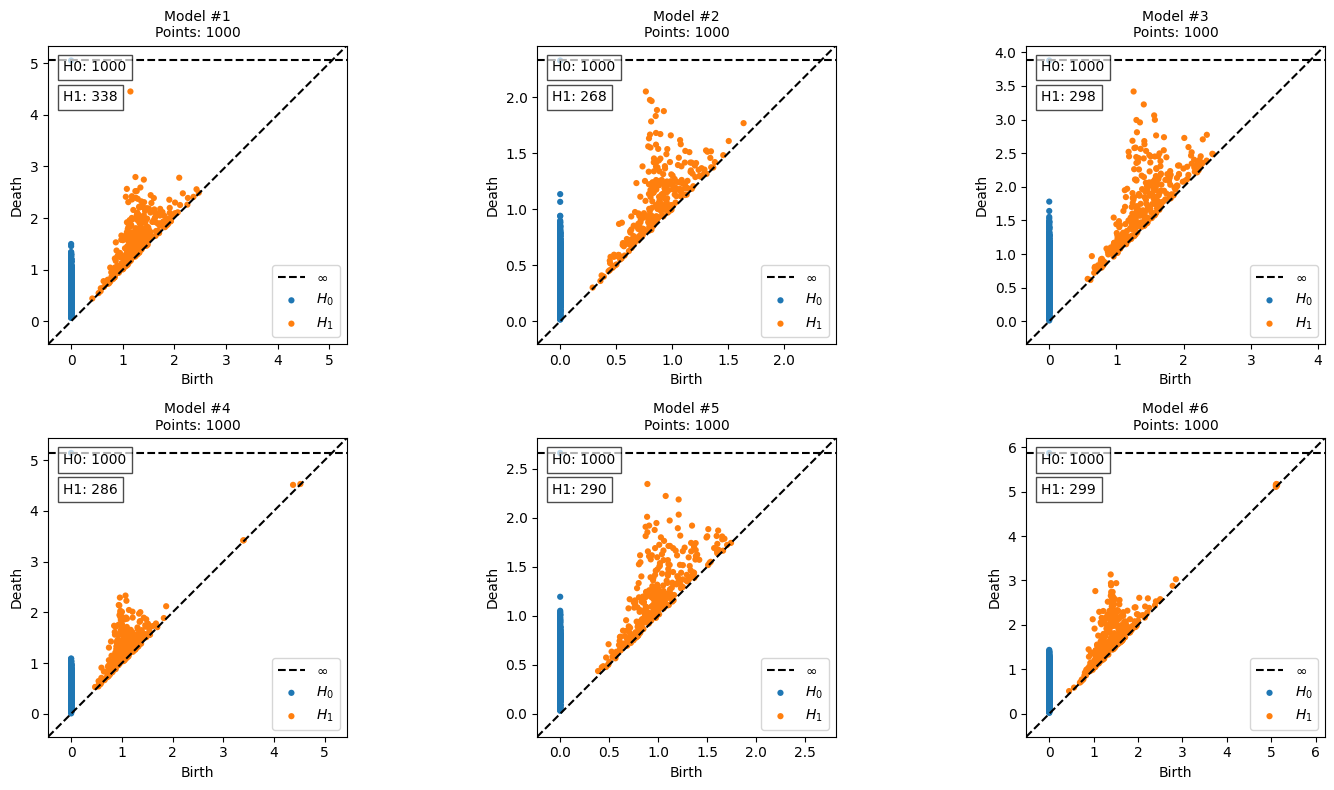

In [183]:
X, y, point_clouds, feature_names = generate_point_clouds(n_samples=6, points_per_model=1000)
analyze_topology(point_clouds)

In [164]:
X, y, point_clouds, feature_names = generate_point_clouds(n_samples=10000, points_per_model=1000)

In [137]:
feature_names

['dim0_persistence_mean',
 'dim0_persistence_max',
 'dim0_persistence_sum',
 'dim0_persistence_std',
 'dim1_persistence_mean',
 'dim1_persistence_max',
 'dim1_persistence_sum',
 'dim1_persistence_std',
 'dim1_num_features']

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [177]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [178]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [187]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.4590
F1 Score: 0.3332
